In [1]:
import numpy as np #basic tutorial
import random #shuffle datas
import pandas as pd #load files
import math #computing log
import matplotlib.pyplot as plt #plot results

In [2]:
class DNN(object):
    #Start building DNN
    #We need conponents of 
    #0. Initail information   //done
    #1. fordward propagation  //done
    #2. backward propagation  //done
    #3. SGD process           //done
    #4. Accurancy             //done  
    #5. activation functions  //done
    #6. objective function    //done
    #7. Leraning rate         //done
    #8. Records(Entro, train, test)  //done
    #9. Plot results          //done
    #10.Debugsssssssssssssssss//????
    #11. softmax ///YES
    
    def __init__(self, layer_size):
        self.layer_num = len(layer_size)
        self.layer_size = layer_size
        self.entropy_record = []
        self.training_error_record = []
        self.testing_error_record = []
        
        
        ## Now, build initial weight and bias
        ## w'*layer + b = next layer
        ## (next size * now size) * (now size * 1) + (next size) = (next size)
        ## bias = next size
        self.weight = [np.random.randn(now_size, next_size) for (now_size, next_size) in zip(layer_size[1:], layer_size[:-1])]
        #self.weight = [np.random.uniform(-(np.sqrt(6/(now_size+next_size))),(np.sqrt(6/(now_size+next_size))),(now_size, next_size)) for (now_size, next_size) in zip(layer_size[1:], layer_size[:-1])]
        self.bias = [np.random.randn(next_size) for next_size in layer_size[1:]] 
        self.velocity_w =  [np.zeros(w.shape) for w in self.weight]
        self.velocity_b = [np.zeros(b.shape) for b in self.bias]
    
    def forward(self, x):
        #last layer should use sigmoid
        #others use relu
        for w, b in zip(self.weight[:-1], self.bias[:-1]):
            ##########
            #x = relu(np.dot(w, x) + b)
            x = sigmoid(np.dot(w, x) + b)
        y = softmax(sigmoid(np.dot(self.weight[-1], x) + self.bias[-1]))
        
        return y
    
    def backpropagation(self, x, y):
        #For x, it's only one data
        #First, feed forward and store every value
        #print('x : ', x)
        n_val = x
        neural_value = [x]
        linear_value = []
        
        #last layer should use sigmoid, while others use relu
        for w, b in zip(self.weight[:-1],self.bias[:-1]):
            z = np.dot(w,n_val)+b
            linear_value.append(z)
            #print(z) ####################
            #n_val = relu(z)
            n_val = sigmoid(z)
            neural_value.append(n_val)
        
        z = np.dot(self.weight[-1],n_val)+self.bias[-1]
        linear_value.append(z)
        n_val = softmax(sigmoid(z))
        neural_value.append(n_val)
            
        #Now, we calculate delta values
        #we need : 1. last layer gap, 2. diff. of activation, 3. previous neural value
        #times them together
        #However, we should handle last layer first
        delta_w = [np.zeros(w.shape) for w in self.weight]
        delta_b = [np.zeros(b.shape) for b in self.bias]
        
        Error = objective_function(neural_value[-1],y)
        #print((neural_value[-1]-y))
        #print(neural_value[-1])
        #print(y)
        #print(objective_function(neural_value[-1],y))
        
        delta = d_obj(neural_value[-1],y)
        #delta = ((neural_value[-1] - y))*(d_sigmoid(linear_value[-1]))
        #delta = d_obj(neural_value[-1],y)*Error*(d_sigmoid(linear_value[-1]))
        #delta = d_obj(neural_value[-1],y)*(d_sigmoid(linear_value[-1]))
        
#         print(delta)
#         #we should times softmax layer first
#         delta = np.dot(delta.reshape(len(delta),1),delta.reshape(len(delta),1).transpose())
#         for i in range(0,len(delta)):
#             for j in range(0,len(delta)):
#                 if(i==j):
#                     delta[i][j] = delta[i][j]*(1-delta[i][j])
#                 else:
#                     delta[i][j] = (-1)*delta[i][j]
        
        
#         print(delta)
        #for bias, only 1 dimension
        delta_b[-1] = delta
        #for weight, should be previous layer's dimension
        #and every neural times delta

        delta_w[-1] = np.dot(delta.reshape(len(delta),1), np.array(neural_value[-2]).reshape(len(np.array(neural_value[-2])),1).transpose())
        #Till now, last layer has done computing delta value
        #Next, we should compute rest layers' delta value
        #by timing their 'next layer' (chain rule)
        #Note that these activation are using relu function
        
        #second layer(first layer is input) to (n-1) layer
        for layer_index in range(2,(self.layer_num)):
            #print(self.weight[-layer_index-2])
            # times w, then times derivative of relu
            #print(layer_index)
            #print(self.weight[-layer_index].shape) #########################
            #delta = np.dot(self.weight[-layer_index+1].transpose(), delta)*d_relu(linear_value[-layer_index])
            delta = np.dot(self.weight[-layer_index+1].transpose(), delta)*d_sigmoid(linear_value[-layer_index])
            delta_b[-layer_index] = delta
            #delta_w need to times previous neural value
            #print(layer_index)
            #print(delta)

            #print(self.weight)
            #print(neural_value)
            #print(self.layer_size)
            #print(delta_w[-layer_index-1])
            delta_w[-layer_index] = np.dot(delta.reshape(len(delta),1), np.array(neural_value[-layer_index-1]).reshape(len(np.array(neural_value[-layer_index-1])),1).transpose())
            #np.dot(delta, np.array(neural_value[-layer_index-2]).transpose())
        
        #Done, return delta table
        return delta_b, delta_w, (np.sum(Error))
    
    #Now, update parameters for every minibatch
    #for every mini-batch, we need to sum up their back prop value
    #then update weight and bias per mini-batch
    def update_parameters(self, mini_batch, learning_rate, training_data, testing_data, alpha):
        
        
        delta_w_total = [np.zeros(w.shape) for w in self.weight]
        delta_b_total = [np.zeros(b.shape) for b in self.bias]
        
        total_entropy = 0
        for x,y in mini_batch:
            delta_b, delta_w, entropy = self.backpropagation(x, y)
            delta_w_total = [dwt+dw for dwt,dw in zip(delta_w_total,delta_w)]
            delta_b_total = [dbt+db for dbt,db in zip(delta_b_total,delta_b)]
            total_entropy += entropy
        
#         w_norm = 0
#         for layer in delta_w_total:
#             for neural in layer:
#                 for num in neural:
#                     #print(num)
#                     w_norm+=num*num
#         w_norm = np.sqrt(w_norm)

#         b_norm = 0
#         for layer in delta_b_total:
#             for num in layer:
#                 b_norm+=num*num
#         b_norm = np.sqrt(b_norm)
 
#         step_size_w = learning_rate*w_norm/(1-alpha)
#         step_size_b = learning_rate*b_norm/(1-alpha)
        step_size_w = learning_rate
        step_size_b = learning_rate
        
        self.velocity_w = [alpha*v - step_size_w*(dwt/len(mini_batch)) for v,dwt in zip(self.velocity_w, delta_w_total)]
        self.velocity_b = [alpha*v - step_size_b*(dbt/len(mini_batch)) for v,dbt in zip(self.velocity_b, delta_b_total)]
        self.weight = [w + v for w,v in zip(self.weight, self.velocity_w)]
        self.bias = [b + v for b,v in zip(self.bias, self.velocity_b)]
        
        #Now, renew weight and bias
        #print(delta_w_total)
#         self.weight = [w - learning_rate*(dwt/len(mini_batch)) for w,dwt in zip(self.weight, delta_w_total)]
#         self.bias = [b - learning_rate*(dbt/len(mini_batch)) for b,dbt in zip(self.bias, delta_b_total)]
        
        self.entropy_record.append(total_entropy/len(mini_batch))
        self.training_error_record.append(self.accuracy(training_data)/len(training_data))
        self.testing_error_record.append(self.accuracy(testing_data)/len(testing_data))
        #print(len(self.training_error_record))
    
    def accuracy(self, data):
        #Last layer are equal 2 in this question
        #that is, surfive/dead are separated into 2 neural
        #the answer will be the largest neural, which we can use argmax
        answers = [(np.argmax(self.forward(x)), np.argmax(y)) for (x,y) in data]
        
        correct_num = 0
        for x,y in answers:
            #print(x)
            #print(y)
            if(x==y):
                correct_num+=1
        
        return correct_num
    
    def SGD(self, training_data, mini_batch_size, epoch, start_learning_rate, testing_data, alpha):
        learning_rate = start_learning_rate
        for epoch_num in range(0,epoch):
            #shuffle data
            random.shuffle(training_data)
            
            #split into mini batch
            mini_batches = [training_data[i:i+mini_batch_size] for i in range(0,len(training_data), mini_batch_size)]
            
            
            for mini_batch in mini_batches:
                try:
                    if(self.training_error_record[-1]<=self.training_error_record[-2]):
                        #then it's increasing, we should slower(decrease) learning rate
                        learning_rate = learning_rate*0.999
                        if(learning_rate<=0.0001):
                            #lower bound of learning rate
                            learning_rate = 0.0001
                        self.update_parameters(mini_batch, learning_rate, training_data, testing_data)
                    else:
                        #learning_rate = learning_rate*0.99
                        self.update_parameters(mini_batch, learning_rate, training_data, testing_data)
                except:
                    #print(mini_batch)
                    self.update_parameters(mini_batch, learning_rate, training_data, testing_data, alpha)
            
            print('{0} epoch / training accuracy : {1} / testing accuracy : {2} / lr : {3}'.format((epoch_num+1), self.training_error_record[-1], self.testing_error_record[-1],learning_rate))
        
    def plot_results(self, mini_batch_size):
        #Entropy
        
        y = [self.entropy_record[i] for i in range(0,len(self.entropy_record), int(800/mini_batch_size))]
        x = list(range(0,len(y)))
        #y = self.entropy_record
        #x = list(range(0,len(y)))
        #print('ya')
        plt.plot(x,y)
        #plt.plot(list(range(0,len(self.entropy_record))), self.entropy_record)
        plt.xlabel('Numbers of epoch')
        #plt.xlabel('Numbers of iteration')
        plt.ylabel('Average of cross entropy')
        plt.title('training loss')
        plt.show()
        
        y = [1-self.training_error_record[i] for i in range(0,len(self.training_error_record), int(800/mini_batch_size))]
        x = list(range(0,len(y)))
        #training_error_rate = [1-acc for acc in self.training_error_record]
        #plt.plot(list(range(0,len(training_error_rate))), training_error_rate)
        plt.plot(x,y)
        plt.xlabel('Numbers of epoch')
        #plt.xlabel('Numbers of iteration')
        plt.ylabel('Error rate')
        plt.title('training error rate')
        plt.show()
        
        
        y = [1-self.testing_error_record[i] for i in range(0,len(self.testing_error_record), int(800/mini_batch_size))]
        x = list(range(0,len(y)))
        plt.plot(x,y)
        #testing_error_rate = [1-acc for acc in self.testing_error_record]
        #plt.plot(list(range(0,len(testing_error_rate))), testing_error_rate)
        plt.xlabel('Numbers of epoch')
        #plt.xlabel('Numbers of iteration')
        plt.ylabel('Error rate')
        plt.title('testing error rate')
        plt.show()
def relu(x):
    try:
        z = []
        #print(x)
        for num in x:
            z.append(max(0,num))
        return z
    except:
        return(max(0,x))

def d_relu(x):    
    #print(x)
    try:
        z = []
        for num in x:
            if(num>=0):
                z.append(float(1.0))
            else:
                z.append(float(0.0))
        return z
    except:
        if(x>=0):
            return (float(1.0))
        else:
            return (float(0.0))

def sigmoid(x):
    return (1.0/(1.0 + np.exp(-x)))

def d_sigmoid(x):
    y = sigmoid(x)
    return y*(1 - y) 

def softmax(x):
    return x/(sum(x))

def objective_function(pre_y, true_y):
#def objective_function(a, y):
    Error = []
    
    for a,b in zip((pre_y), (true_y)):
        #print(a,b)
        if(a==0):
            a = 10**(-10)
        Error.append(b*(math.log(a)))
        #Error.append(b*(math.log(a))+(1-b)*(math.log(1-a)))
        #print('Error : ',Error)
    #print(Error)
    #Error = [b*(math.log(a)) for a,b in zip(pre_y, true_y)]
    return (np.dot((-1),(np.array(Error))))
    #return (np.nan_to_num(-true_y*np.log(pre_y)-(1-true_y)*np.log(1-pre_y)))

def d_obj(pre_y, true_y):
    Error = []
    count = 0
    for a,b in zip((pre_y), (true_y)):
        #print(a,b)
        Error.append(a-b)
        if(a==0):
            a = 0.00000001
        elif(a==1):
            a = 0.99999999
        #Error.append((-b/a))
        #Error.append((a-b)/(a*(1-a)))
        #print('Error : ',Error)
    #print(Error)
    #Error = [b*(math.log(a)) for a,b in zip(pre_y, true_y)]
    #return np.dot((-1),((Error)))
    return np.array(Error)

# p1 : Desine own structures

In [3]:
###Now, start dealing with data preprocessing

data = pd.read_csv('titanic.csv')
answers = np.array(pd.get_dummies(data['Survived'].values).values)
data = data.drop(columns=['Survived'])
for num in range(0,len(data)):
    data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
    data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
# Pclass = pd.get_dummies(data['Pclass'])
# data = data.drop(columns=['Pclass'])
# data = data.join(Pclass)
    
training_data = data[:800]
testing_data = data[800:]
training_ans = answers[0:800]
testing_ans = answers[800:]


train = [[a,b] for a, b in zip(np.array(training_data.values), training_ans)]
test = [[a,b] for a, b in zip(np.array(testing_data.values), testing_ans)]


In [4]:

My_network = DNN([6,32,32,32,2])
mini_batch_size = 50
epoch = 100
start_learning_rate = 0.02
alpha = 0.99
My_network.SGD(train, mini_batch_size, epoch, start_learning_rate, test, alpha)

1 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.01972181273998002
2 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.019428047392654364
3 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.019119519155626808
4 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018834725244463356
5 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.01855417346780002
6 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01827780063711903
7 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.01800554450512425
8 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.017755098850571836
9 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.017490628598805073
10 epoch / training accuracy : 0.615 / testing accuracy : 0.626

79 epoch / training accuracy : 0.8125 / testing accuracy : 0.7912087912087912 / lr : 0.008408969927955215
80 epoch / training accuracy : 0.8175 / testing accuracy : 0.8021978021978022 / lr : 0.008325257625009795
81 epoch / training accuracy : 0.80875 / testing accuracy : 0.8021978021978022 / lr : 0.008225902173070666
82 epoch / training accuracy : 0.81875 / testing accuracy : 0.8021978021978022 / lr : 0.00816849331418596
83 epoch / training accuracy : 0.82 / testing accuracy : 0.8021978021978022 / lr : 0.00809527025499236
84 epoch / training accuracy : 0.81375 / testing accuracy : 0.8021978021978022 / lr : 0.00801468086986945
85 epoch / training accuracy : 0.815 / testing accuracy : 0.7912087912087912 / lr : 0.00794283659832759
86 epoch / training accuracy : 0.815 / testing accuracy : 0.7912087912087912 / lr : 0.007855900943808326
87 epoch / training accuracy : 0.815 / testing accuracy : 0.8021978021978022 / lr : 0.00776991681434351
88 epoch / training accuracy : 0.81625 / testing accu

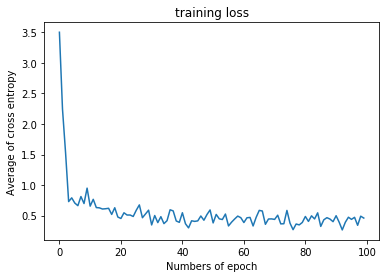

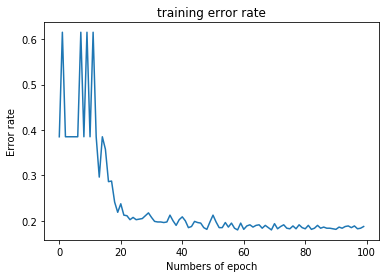

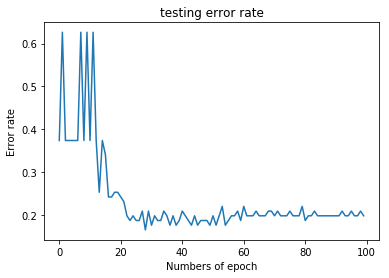

In [5]:
My_network.plot_results(mini_batch_size)

# p2 : Structures with [6,3,3,2]

In [59]:
###Now, start dealing with data preprocessing

data = pd.read_csv('titanic.csv')
answers = np.array(pd.get_dummies(data['Survived'].values).values)
data = data.drop(columns=['Survived'])
for num in range(0,len(data)):
    data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
    data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
#Pclass = pd.get_dummies(data['Pclass'])
#data = data.drop(columns=['Pclass'])
#data = data.join(Pclass)
    
training_data = data[:800]
testing_data = data[800:]
training_ans = answers[0:800]
testing_ans = answers[800:]


train = [[a,b] for a, b in zip(np.array(training_data.values), training_ans)]
test = [[a,b] for a, b in zip(np.array(testing_data.values), testing_ans)]

First_network = DNN([6,3,3,2])
mini_batch_size = 50
epoch = 100
start_learning_rate = 0.015
alpha = 0.99
First_network.SGD(train, mini_batch_size, epoch, start_learning_rate, test, alpha)


1 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.014806165720705717
2 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.014571035544490771
3 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01433963936672011
4 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.014111917889414172
5 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01388781275627842
6 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01366726653774884
7 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.013450222716274962
8 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.013236625671836557
9 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01302642066769036
10 epoch / training accuracy : 0.615 / testing accuracy : 0.62637362

79 epoch / training accuracy : 0.81875 / testing accuracy : 0.7912087912087912 / lr : 0.005809972774410747
80 epoch / training accuracy : 0.8175 / testing accuracy : 0.7802197802197802 / lr : 0.005740635283998261
81 epoch / training accuracy : 0.81625 / testing accuracy : 0.7912087912087912 / lr : 0.0056494707913555394
82 epoch / training accuracy : 0.815 / testing accuracy : 0.7912087912087912 / lr : 0.005565319361103679
83 epoch / training accuracy : 0.82 / testing accuracy : 0.8131868131868132 / lr : 0.005504406024252692
84 epoch / training accuracy : 0.82 / testing accuracy : 0.7912087912087912 / lr : 0.005433276519275751
85 epoch / training accuracy : 0.82125 / testing accuracy : 0.7912087912087912 / lr : 0.005368434604659054
86 epoch / training accuracy : 0.81875 / testing accuracy : 0.8131868131868132 / lr : 0.005299062161156884
87 epoch / training accuracy : 0.81875 / testing accuracy : 0.8021978021978022 / lr : 0.005230586168160657
88 epoch / training accuracy : 0.81875 / test

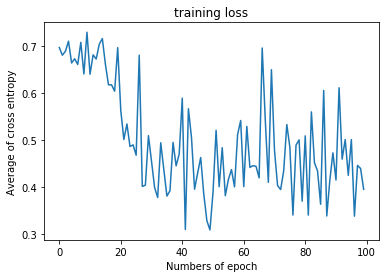

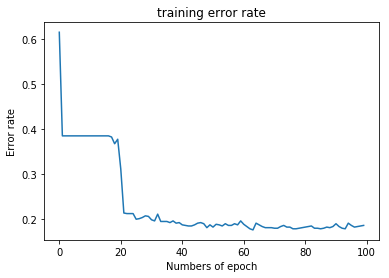

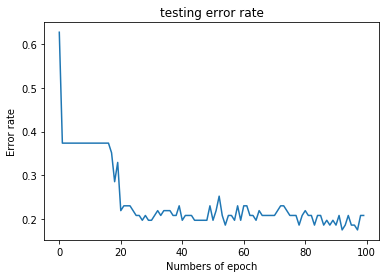

In [60]:
First_network.plot_results(mini_batch_size)

# p3: normalization?

In [8]:
###Now, start dealing with data preprocessing

data = pd.read_csv('titanic.csv')
answers = np.array(pd.get_dummies(data['Survived'].values).values)
data = data.drop(columns=['Survived'])
# for num in range(0,len(data)):
#     data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
#     data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
# Pclass = pd.get_dummies(data['Pclass'])
# data = data.drop(columns=['Pclass'])
# data = data.join(Pclass)
    
training_data = data[:800]
testing_data = data[800:]
training_ans = answers[0:800]
testing_ans = answers[800:]


train = [[a,b] for a, b in zip(np.array(training_data.values), training_ans)]
test = [[a,b] for a, b in zip(np.array(testing_data.values), testing_ans)]

sec_network = DNN([6,32,32,32,2])
mini_batch_size = 50
epoch = 100
start_learning_rate = 0.02
alpha = 0.99
sec_network.SGD(train, mini_batch_size, epoch, start_learning_rate, test, alpha)


C:\Users\jeffp\Anaconda3\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: overflow encountered in exp


1 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.019741554294274294
2 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.019428047392654364
3 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01915781562906932
4 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.018853578823286643
5 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018647223298438244
6 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018351094983870643
7 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018059669352232563
8 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01777287172229413
9 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.017490628598805073
10 epoch / training accuracy : 0.615 / testing accuracy : 0.6263

79 epoch / training accuracy : 0.69875 / testing accuracy : 0.7252747252747253 / lr : 0.007879515860722427
80 epoch / training accuracy : 0.7125 / testing accuracy : 0.7472527472527473 / lr : 0.007785479988841203
81 epoch / training accuracy : 0.70125 / testing accuracy : 0.7362637362637363 / lr : 0.007684873795334731
82 epoch / training accuracy : 0.72125 / testing accuracy : 0.7472527472527473 / lr : 0.007631240792415317
83 epoch / training accuracy : 0.72 / testing accuracy : 0.7582417582417582 / lr : 0.007547715605302386
84 epoch / training accuracy : 0.7225 / testing accuracy : 0.7582417582417582 / lr : 0.007480057249558407
85 epoch / training accuracy : 0.71625 / testing accuracy : 0.7362637362637363 / lr : 0.007390788604426293
86 epoch / training accuracy : 0.7225 / testing accuracy : 0.7582417582417582 / lr : 0.007331868824304586
87 epoch / training accuracy : 0.72125 / testing accuracy : 0.7472527472527473 / lr : 0.007251620312680348
88 epoch / training accuracy : 0.72375 / te

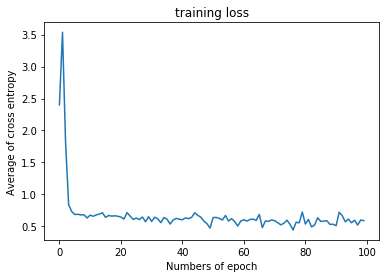

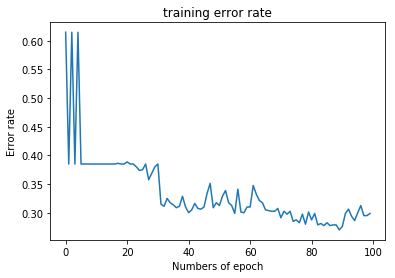

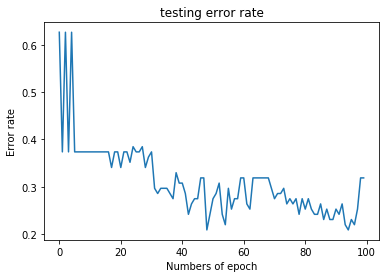

In [9]:
sec_network.plot_results(mini_batch_size)

In [10]:
###Now, start dealing with data preprocessing

data = pd.read_csv('titanic.csv')
answers = np.array(pd.get_dummies(data['Survived'].values).values)
data = data.drop(columns=['Survived'])
for num in range(0,len(data)):
#     data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
     data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
# Pclass = pd.get_dummies(data['Pclass'])
# data = data.drop(columns=['Pclass'])
# data = data.join(Pclass)
    
training_data = data[:800]
testing_data = data[800:]
training_ans = answers[0:800]
testing_ans = answers[800:]


train = [[a,b] for a, b in zip(np.array(training_data.values), training_ans)]
test = [[a,b] for a, b in zip(np.array(testing_data.values), testing_ans)]

sec_network = DNN([6,32,32,32,2])
mini_batch_size = 50
epoch = 100
start_learning_rate = 0.02
alpha = 0.99
sec_network.SGD(train, mini_batch_size, epoch, start_learning_rate, test, alpha)


1 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.019800897604194966
2 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.019564589345774805
3 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.019273165912228343
4 epoch / training accuracy : 0.4875 / testing accuracy : 0.4835164835164835 / lr : 0.01904315571966028
5 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018778277554070973
6 epoch / training accuracy : 0.6225 / testing accuracy : 0.6263736263736264 / lr : 0.018498566591362852
7 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.018204799028281454
8 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.017915696658078243
9 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.01763118539488629
10 epoch / training accuracy : 0.63 / testing accuracy : 0.61538

79 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.006521940145097747
80 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.0064183680951486076
81 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.006322763590755715
82 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.006228583158825591
83 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.006129669781565737
84 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.00603232720394867
85 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.0059365304807992665
86 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.005842255063085708
87 epoch / training accuracy : 0.68625 / testing accuracy : 0.6813186813186813 / lr : 0.005749476791628503
88 epoch / training accuracy : 0.686

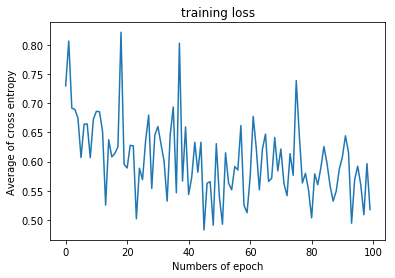

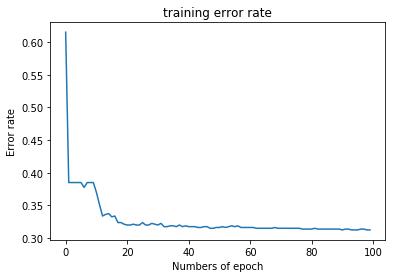

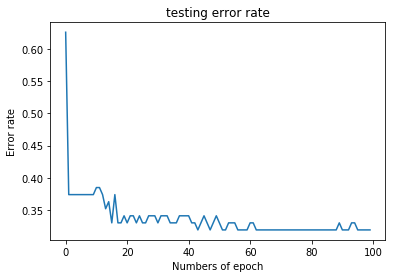

In [11]:
sec_network.plot_results(mini_batch_size)

# p4 : What feature affects most?

## However, from p3 result, 'Age' does not affect most for sure

In [12]:
data = pd.read_csv('titanic.csv')
data.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.543351,0.010539,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,0.131900,-0.361353,0.083081,0.018443,-0.549500
Sex,-0.543351,0.131900,1.000000,0.024978,-0.114631,-0.245489,-0.182333
Age,0.010539,-0.361353,0.024978,1.000000,-0.184664,-0.048786,0.135516
SibSp,-0.035322,0.083081,-0.114631,-0.184664,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.245489,-0.048786,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,-0.182333,0.135516,0.159651,0.216225,1.000000


'Sex' > 'Pclass' > 'Fare' > 'Parch' > 'SibSp' > 'Age'

## p5 : Should we use one-hot for Pclass?

In [57]:
###Now, start dealing with data preprocessing

data = pd.read_csv('titanic.csv')
answers = np.array(pd.get_dummies(data['Survived'].values).values)
data = data.drop(columns=['Survived'])
for num in range(0,len(data)):
    data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
    data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
Pclass = pd.get_dummies(data['Pclass'])
data = data.drop(columns=['Pclass'])
data = data.join(Pclass)
    
training_data = data[:800]
testing_data = data[800:]
training_ans = answers[0:800]
testing_ans = answers[800:]


train = [[a,b] for a, b in zip(np.array(training_data.values), training_ans)]
test = [[a,b] for a, b in zip(np.array(testing_data.values), testing_ans)]

First_network = DNN([8,32,32,32,2])
mini_batch_size = 50
epoch = 100
start_learning_rate = 0.02
alpha = 0.99
First_network.SGD(train, mini_batch_size, epoch, start_learning_rate, test, alpha)


1 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.00988065780494209
2 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.009723747443770954
3 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.00957890781453466
4 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.009455126435024216
5 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.009304973749532333
6 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.009157205572498942
7 epoch / training accuracy : 0.385 / testing accuracy : 0.37362637362637363 / lr : 0.009020804841440164
8 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.008922070646990504
9 epoch / training accuracy : 0.615 / testing accuracy : 0.6263736263736264 / lr : 0.008780383184956003
10 epoch / training accuracy : 0.60625 / testing accuracy : 0.61

79 epoch / training accuracy : 0.81875 / testing accuracy : 0.7802197802197802 / lr : 0.003959515954549783
80 epoch / training accuracy : 0.81875 / testing accuracy : 0.8021978021978022 / lr : 0.003908349959789492
81 epoch / training accuracy : 0.8175 / testing accuracy : 0.8131868131868132 / lr : 0.003850133314162376
82 epoch / training accuracy : 0.82 / testing accuracy : 0.7692307692307693 / lr : 0.0038041849780646037
83 epoch / training accuracy : 0.8225 / testing accuracy : 0.7802197802197802 / lr : 0.003751271188281755
84 epoch / training accuracy : 0.81 / testing accuracy : 0.8131868131868132 / lr : 0.0037027961918005554
85 epoch / training accuracy : 0.8175 / testing accuracy : 0.8131868131868132 / lr : 0.0036586062092624004
86 epoch / training accuracy : 0.82 / testing accuracy : 0.7692307692307693 / lr : 0.0036294395959361103
87 epoch / training accuracy : 0.82125 / testing accuracy : 0.7692307692307693 / lr : 0.003578956403106036
88 epoch / training accuracy : 0.81125 / test

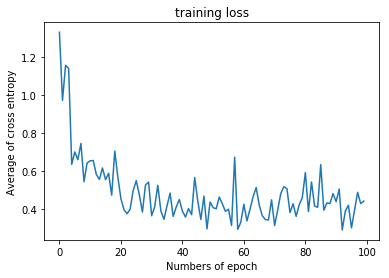

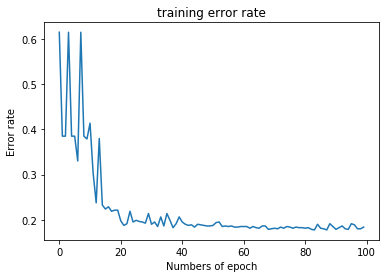

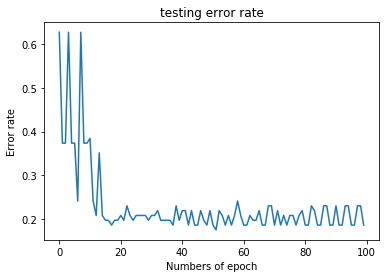

In [58]:
First_network.plot_results(mini_batch_size)

In [16]:
data = pd.read_csv('titanic.csv')
# answers = np.array(pd.get_dummies(data['Survived'].values).values)
# data = data.drop(columns=['Survived'])
# for num in range(0,len(data)):
#     data.loc[num,'Age'] = data.loc[num,'Age']/(np.max(data['Age'])-np.min(data['Age']))
#     data.loc[num,'Fare'] = data.loc[num,'Fare']/(np.max(data['Fare'])-np.min(data['Fare']))
Pclass = pd.get_dummies(data['Pclass'])
data = data.drop(columns=['Pclass'])
data = data.join(Pclass)
data.corr()

,Survived,Sex,Age,SibSp,Parch,Fare,1,2,3
Survived,1.000000,-0.543351,0.010539,-0.035322,0.081629,0.257307,0.285904,0.093349,-0.322308
Sex,-0.543351,1.000000,0.024978,-0.114631,-0.245489,-0.182333,-0.098013,-0.064746,0.137143
Age,0.010539,0.024978,1.000000,-0.184664,-0.048786,0.135516,0.293485,0.124510,-0.354201
SibSp,-0.035322,-0.114631,-0.184664,1.000000,0.414838,0.159651,-0.054582,-0.055932,0.092548
Parch,0.081629,-0.245489,-0.048786,0.414838,1.000000,0.216225,-0.017633,-0.000734,0.015790
Fare,0.257307,-0.182333,0.135516,0.159651,0.216225,1.000000,0.591711,-0.118557,-0.413333
1,0.285904,-0.098013,0.293485,-0.054582,-0.017633,0.591711,1.000000,-0.288585,-0.626738
2,0.093349,-0.064746,0.124510,-0.055932,-0.000734,-0.118557,-0.288585,1.000000,-0.565210
3,-0.322308,0.137143,-0.354201,0.092548,0.015790,-0.413333,-0.626738,-0.565210,1.000000


In [17]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,1,2,3
0,0,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0
4,0,1,35.0,0,0,8.0500,0,0,1


survival : 1>2>3, fit as the distance without one-hot encoding

## p6 : Desine own data 

In [18]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,1,2,3
0,0,1,22.0,1,0,7.2500,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0
4,0,1,35.0,0,0,8.0500,0,0,1


In [56]:
### 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'
survive = [1,0,0.24,0,0,0.82]
print(survive)
print(np.argmax(My_network.forward(survive)))

print('\n')
dead = [3,1,0.75,1,2,0.14]
print(dead)
print(np.argmax(My_network.forward(dead)))

[1, 0, 0.24, 0, 0, 0.82]
1


[3, 1, 0.75, 1, 2, 0.14]
0


In [20]:
testing_data.iloc[88]

Sex      0.000000
Age      0.000000
SibSp    1.000000
Parch    2.000000
Fare     0.781667
1        0.000000
2        0.000000
3        1.000000
Name: 888, dtype: float64